<a href="https://colab.research.google.com/github/benjuarez8/CS81C-Research-Bolivia/blob/main/cs81c_visuals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**USING AVG. ENSEMBLE PREDICTIONS

*   VS = vote stealing
*   BBS = ballot box stuffing



#Imports

In [1]:
pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 5.2 MB/s 
     |████████████████████████████████| 6.3 MB 49.4 MB/s 
     |████████████████████████████████| 16.7 MB 274 kB/s 


In [2]:
pip install Unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 235 kB 5.1 MB/s 


In [3]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from unidecode import unidecode
import seaborn as sns
sns.set(style="darkgrid")

In [4]:
warnings.simplefilter(action='ignore', category=UserWarning)

#Loading Shape Files

Department-level shape file from https://geodata.lib.berkeley.edu/catalog/stanford-kc253vd8155

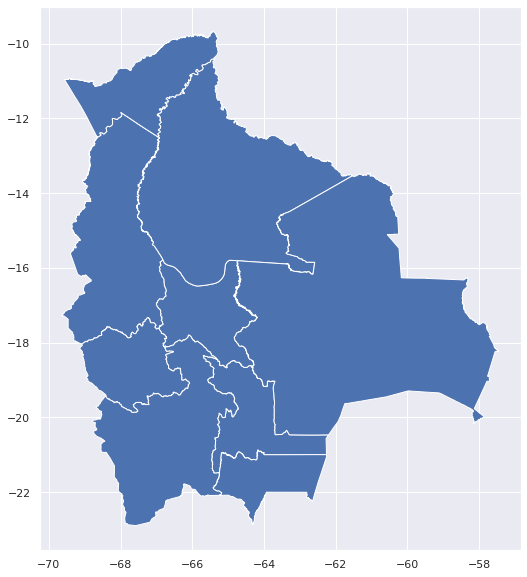

In [5]:
departments = gpd.read_file("/content/kc253vd8155.shp")
# departments = departments.to_crs(epsg=4326)
departments.plot(figsize=(20,10))
plt.show()

In [6]:
departments.sample(9)

,id_0,iso,name_0,id_1,name_1,hasc_1,ccn_1,cca_1,type_1,engtype_1,nl_name_1,varname_1,geometry
2,28.0,BOL,Bolivia,3.0,El Beni,BO.EB,0.0,None,Departamento,Department,None,None,"POLYGON ((-65.38693 -10.40419, -65.38508 -10.4..."
5,28.0,BOL,Bolivia,6.0,Pando,BO.PA,0.0,None,Departamento,Department,None,colonial territories|madre de dios|territorio ...,"POLYGON ((-65.32160 -9.80977, -65.32056 -9.814..."
3,28.0,BOL,Bolivia,4.0,La Paz,BO.LP,0.0,None,Departamento,Department,None,None,"POLYGON ((-67.79647 -11.96319, -67.68695 -12.0..."
8,28.0,BOL,Bolivia,9.0,Tarija,BO.TR,0.0,None,Departamento,Department,None,None,"POLYGON ((-64.16827 -20.87689, -64.16255 -20.8..."
0,28.0,BOL,Bolivia,1.0,Chuquisaca,BO.CQ,0.0,None,Departamento,Department,None,None,"POLYGON ((-65.63209 -18.36710, -65.63008 -18.3..."
6,28.0,BOL,Bolivia,7.0,Potosí,BO.PO,0.0,None,Departamento,Department,None,None,"POLYGON ((-65.98185 -17.92597, -65.97605 -17.9..."
7,28.0,BOL,Bolivia,8.0,Santa Cruz,BO.SC,0.0,None,Departamento,Department,None,None,"POLYGON ((-61.02828 -13.47741, -61.02672 -13.4..."
1,28.0,BOL,Bolivia,2.0,Cochabamba,BO.CB,0.0,None,Departamento,Department,None,None,"POLYGON ((-66.64576 -15.93596, -66.63350 -15.9..."
4,28.0,BOL,Bolivia,5.0,Oruro,BO.OR,0.0,None,Departamento,Department,None,None,"POLYGON ((-67.21564 -17.35314, -67.20990 -17.3..."


In [7]:
departments['Department'] = departments['name_1']
departments['Department'] = departments['Department'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

Municipality-level shape file from https://maps.princeton.edu/catalog/stanford-xg218hn4313

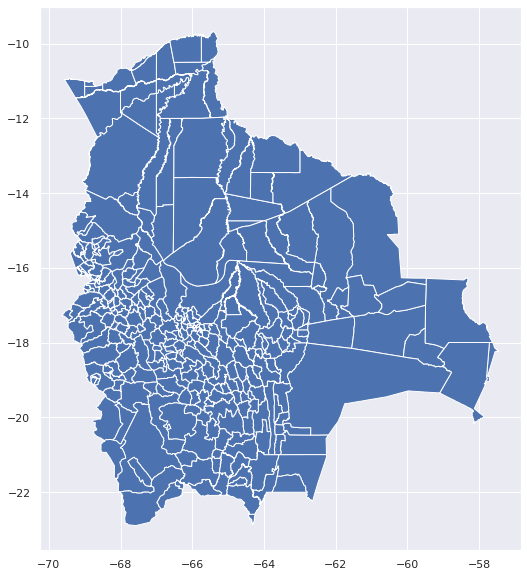

In [8]:
bolivia = gpd.read_file("BOL_adm3.shp")
bolivia.plot(figsize=(20,10))
plt.show()

In [9]:
len(bolivia)

319

In [10]:
bolivia['Municipality'] = bolivia['NAME_3']
bolivia['Municipality'] = bolivia['Municipality'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
bolivia['Municipality'] = bolivia['Municipality'].str.replace(' ', '')
bolivia['Municipality'] = bolivia['Municipality'].str.replace('"', '').str.lower().str.replace(r"\(.*\)","", regex=True)
bolivia['Municipality'] = bolivia['Municipality'].str.replace('sanpedrodebuenavista', 'sanpedro')
bolivia.sample(5)

,ID_0,ISO,NAME_0,ID_1,NAME_1,ID_2,NAME_2,ID_3,NAME_3,CCN_3,CCA_3,TYPE_3,ENGTYPE_3,NL_NAME_3,VARNAME_3,geometry,Municipality
97,28,BOL,Bolivia,4,La Paz,33,Aroma,98,Colquencha,0,None,Município,Municipality,None,None,"POLYGON ((-68.15162 -17.03531, -68.16317 -17.0...",colquencha
147,28,BOL,Bolivia,4,La Paz,45,Nor Yungas,148,Coroico,0,None,Município,Municipality,None,None,"POLYGON ((-67.54699 -16.03788, -67.54942 -16.0...",coroico
203,28,BOL,Bolivia,5,Oruro,58,Sajama,204,Totora,0,None,Município,Municipality,None,None,"POLYGON ((-67.93858 -17.94452, -67.94700 -17.9...",totora
238,28,BOL,Bolivia,7,Potosí,69,Daniel Campos,239,Tahua,0,None,Município,Municipality,None,None,"POLYGON ((-68.03084 -19.61814, -68.02904 -19.6...",tahua
38,28,BOL,Bolivia,2,Cochabamba,14,Capinota,39,Sicaya,0,None,Município,Municipality,None,None,"POLYGON ((-66.37936 -17.68629, -66.37390 -17.6...",sicaya


#Loading & Processing Ensemble Results

Loading department-level results

In [11]:
dep_results = pd.read_csv("ensemble_avg_dep_results.csv")
dep_results['Department'] = dep_results['Department'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
dep_results['Department'] = dep_results['Department'].str.replace('Beni', 'El Beni')
dep_results

,Department,Clean,At_Risk,BBS_Risk,VS_Risk,Avg_Turnout,Avg_MAS_vote
0,Cochabamba,77.37,22.63,11.39,11.24,90.28,0.57
1,La Paz,83.84,16.16,12.88,3.28,91.75,0.53
2,Potosi,86.74,13.26,6.72,6.54,88.87,0.46
3,Oruro,86.75,13.25,11.11,2.13,91.09,0.47
4,Santa Cruz,90.52,9.48,7.56,1.92,88.83,0.34
5,Chuquisaca,91.43,8.57,5.69,2.88,88.41,0.40
6,Tarija,94.36,5.64,2.85,2.79,87.26,0.39
7,El Beni,95.06,4.94,2.70,2.24,86.17,0.34
8,Pando,95.42,4.58,3.05,1.53,84.31,0.43


Loading municipality-level results.  Manipulation was required to match up municipality naming between shape file and original election dataset.  We acknowledge that approx ~20 municipalities had naming issues that could not be solved

In [12]:
mun_results = pd.read_csv("ensemble_avg_mun_results.csv")
mun_results['Municipality'] = mun_results['Municipality'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
mun_results['Municipality'] = mun_results['Municipality'].str.replace(' ', '').str.lower().str.replace(r"\(.*\)","", regex=True)
mun_results['Municipality'] = mun_results['Municipality'].str.replace('puertomenorderurrenabaque', 'puertorurrenabaque')
mun_results['Municipality'] = mun_results['Municipality'].str.replace('puertomayordecarabuco', 'puertocarabuco')
mun_results['Municipality'] = mun_results['Municipality'].str.replace('puertomayordeguaqui', 'guaqui')
mun_results['Municipality'] = mun_results['Municipality'].str.replace('guayaramerin', 'puertoguayaramerin')
mun_results['Municipality'] = mun_results['Municipality'].str.replace('villaricardomugia-icla', 'icla')
# ensemble_avg_mun_results['Municipality'] = ensemble_avg_mun_results['Municipality'].str.replace('sanignacio', 'sanignaciodevelasco')
mun_results['Municipality'] = mun_results['Municipality'].str.replace('sanjose', 'sanjosedechiquitos')
mun_results['Municipality'] = mun_results['Municipality'].str.replace('sanmiguel', 'sanmigueldevelasco')
mun_results['Municipality'] = mun_results['Municipality'].str.replace('sanpablo', 'sanpablodelipez')
mun_results['Municipality'] = mun_results['Municipality'].str.replace('santaana', 'santaanadelyacuma')
mun_results['Municipality'] = mun_results['Municipality'].str.replace('alcala', 'villaalcala')
mun_results['Municipality'] = mun_results['Municipality'].str.replace('azurduy', 'villaazurduy')
mun_results['Municipality'] = mun_results['Municipality'].str.replace('vitiche', 'vitiche')
mun_results['Municipality'] = mun_results['Municipality'].str.replace('zudanez', 'villazudanez')
mun_results['Municipality'] = mun_results['Municipality'].str.replace('sanlorenzo', 'villasanlorenzo')
mun_results['Municipality'] = mun_results['Municipality'].str.replace('huacaya', 'villadehuacaya')
mun_results['Municipality'] = mun_results['Municipality'].str.replace('sopachui', 'sopachuy')
mun_results['Municipality'] = mun_results['Municipality'].str.replace('santarosa', 'santarosadelsara')
mun_results['Municipality'] = mun_results['Municipality'].str.replace('villaancoraimes', 'ancoraimes')
mun_results['Municipality'] = mun_results['Municipality'].str.replace('ravelo', 'avelo')
mun_results['Municipality'] = mun_results['Municipality'].str.replace('vitiche', 'vitichi')
mun_results['Municipality'] = mun_results['Municipality'].str.replace('toco', 'toko')
mun_results['Municipality'] = mun_results['Municipality'].str.replace('generalsaavedra', 'agustinsaavedra')
mun_results['Municipality'] = mun_results['Municipality'].str.replace('ascenciondeguarayos', 'ascensiondeguarayos')
mun_results.head()

,Municipality,Department,Clean,At_Risk,BBS_Risk,VS_Risk,Avg_Turnout,Avg_MAS_vote
0,malla,La Paz,0.0,100.0,66.67,33.33,96.27,0.83
1,sanpablodelipez,Potosí,0.0,100.0,100.00,0.00,94.30,0.40
2,vilavila,Cochabamba,0.0,100.0,50.00,50.00,93.65,0.95
3,raqaypampa,Cochabamba,0.0,100.0,0.00,100.00,89.97,0.96
4,catacora,La Paz,0.0,100.0,0.00,100.00,93.50,0.79


In [13]:
len(mun_results)

326

#Results by Department

Merging predictions and shape file data

In [14]:
dep_merged = departments.set_index('Department').join(dep_results.set_index('Department'))
dep_merged = dep_merged.reset_index()
dep_merged.sample(9)

,Department,id_0,iso,name_0,id_1,name_1,hasc_1,ccn_1,cca_1,type_1,engtype_1,nl_name_1,varname_1,geometry,Clean,At_Risk,BBS_Risk,VS_Risk,Avg_Turnout,Avg_MAS_vote
5,Pando,28.0,BOL,Bolivia,6.0,Pando,BO.PA,0.0,None,Departamento,Department,None,colonial territories|madre de dios|territorio ...,"POLYGON ((-65.32160 -9.80977, -65.32056 -9.814...",95.42,4.58,3.05,1.53,84.31,0.43
8,Tarija,28.0,BOL,Bolivia,9.0,Tarija,BO.TR,0.0,None,Departamento,Department,None,None,"POLYGON ((-64.16827 -20.87689, -64.16255 -20.8...",94.36,5.64,2.85,2.79,87.26,0.39
3,La Paz,28.0,BOL,Bolivia,4.0,La Paz,BO.LP,0.0,None,Departamento,Department,None,None,"POLYGON ((-67.79647 -11.96319, -67.68695 -12.0...",83.84,16.16,12.88,3.28,91.75,0.53
2,El Beni,28.0,BOL,Bolivia,3.0,El Beni,BO.EB,0.0,None,Departamento,Department,None,None,"POLYGON ((-65.38693 -10.40419, -65.38508 -10.4...",95.06,4.94,2.70,2.24,86.17,0.34
6,Potosi,28.0,BOL,Bolivia,7.0,Potosí,BO.PO,0.0,None,Departamento,Department,None,None,"POLYGON ((-65.98185 -17.92597, -65.97605 -17.9...",86.74,13.26,6.72,6.54,88.87,0.46
1,Cochabamba,28.0,BOL,Bolivia,2.0,Cochabamba,BO.CB,0.0,None,Departamento,Department,None,None,"POLYGON ((-66.64576 -15.93596, -66.63350 -15.9...",77.37,22.63,11.39,11.24,90.28,0.57
4,Oruro,28.0,BOL,Bolivia,5.0,Oruro,BO.OR,0.0,None,Departamento,Department,None,None,"POLYGON ((-67.21564 -17.35314, -67.20990 -17.3...",86.75,13.25,11.11,2.13,91.09,0.47
7,Santa Cruz,28.0,BOL,Bolivia,8.0,Santa Cruz,BO.SC,0.0,None,Departamento,Department,None,None,"POLYGON ((-61.02828 -13.47741, -61.02672 -13.4...",90.52,9.48,7.56,1.92,88.83,0.34
0,Chuquisaca,28.0,BOL,Bolivia,1.0,Chuquisaca,BO.CQ,0.0,None,Departamento,Department,None,None,"POLYGON ((-65.63209 -18.36710, -65.63008 -18.3...",91.43,8.57,5.69,2.88,88.41,0.40


At Risk (both VS and BBS)

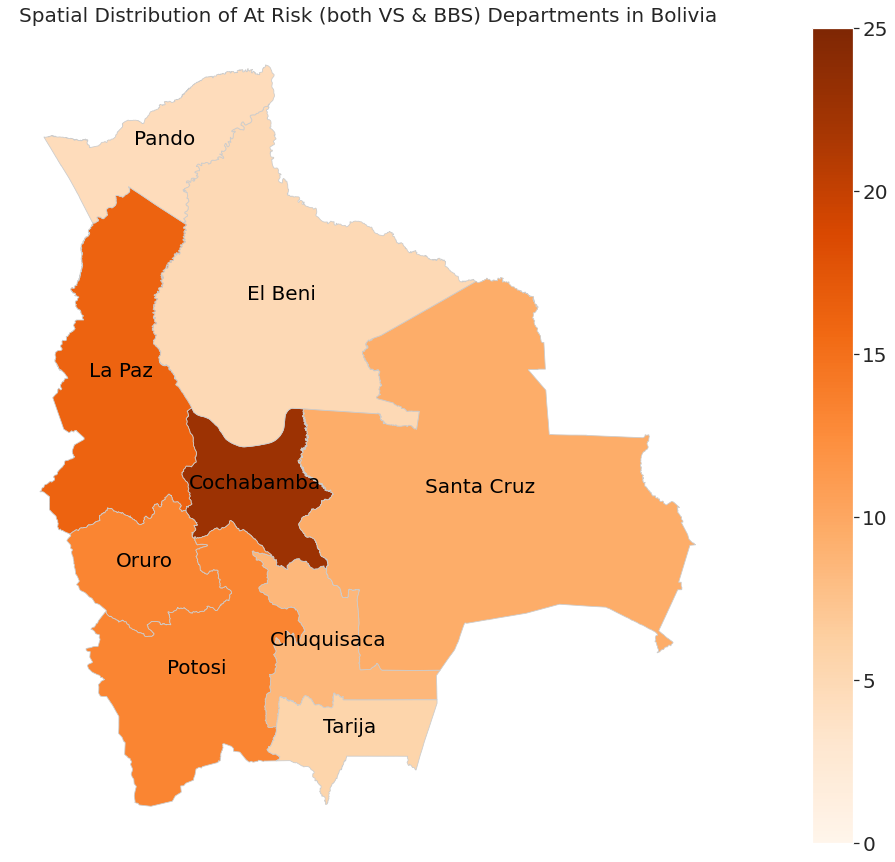

In [15]:
fig, ax = plt.subplots(1, figsize=(30, 15))
ax.axis('off')
ax.set_title('Spatial Distribution of At Risk (both VS & BBS) Departments in Bolivia', fontdict={'fontsize': '20', 'fontweight' : '3'})
color = 'Oranges'
vmin, vmax = 0, 25
# vmin, vmax = dep_merged.At_Risk.min(), dep_merged.At_Risk.max()
sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)
cbar.ax.tick_params(labelsize=20)
dep_merged.plot('At_Risk', cmap=color, vmin=vmin, vmax=vmax, linewidth=0.8, ax=ax, edgecolor='0.8', figsize=(30,15))
for x, y, label in zip(departments.geometry.centroid.x, departments.geometry.centroid.y, dep_merged.Department):
  ax.annotate(s=label, xy=(x,y), horizontalalignment='center', fontsize=20, color='black', wrap=True)
plt.show()

At Risk of VS

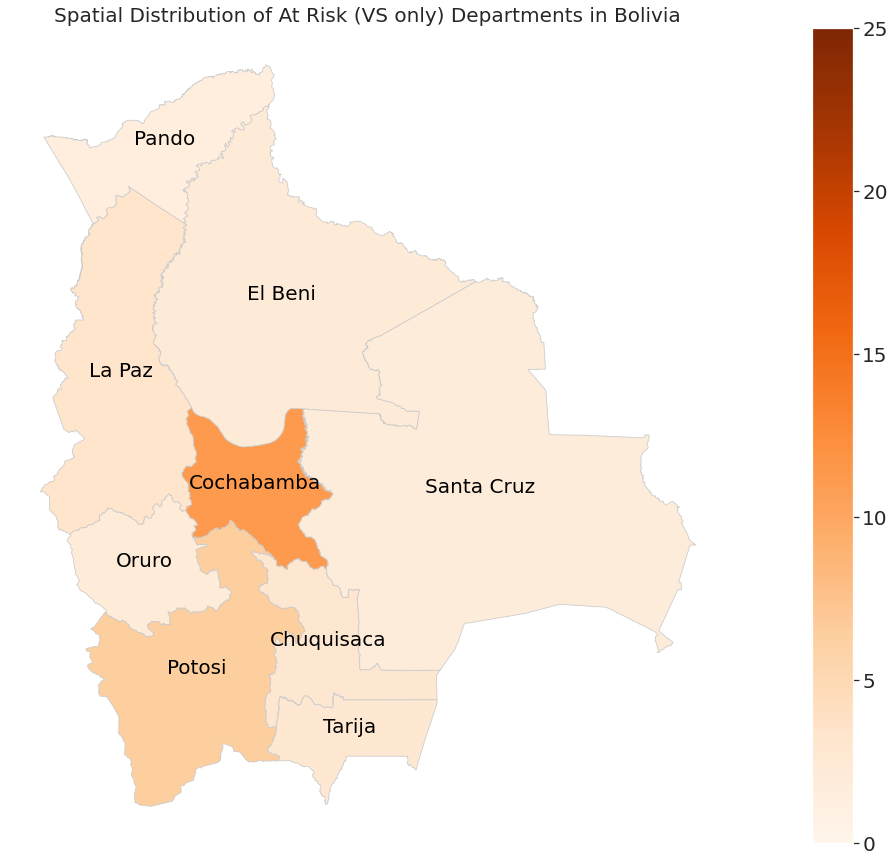

In [16]:
fig, ax = plt.subplots(1, figsize=(30, 15))
ax.axis('off')
ax.set_title('Spatial Distribution of At Risk (VS only) Departments in Bolivia', fontdict={'fontsize': '20', 'fontweight' : '3'})
color = 'Oranges'
vmin, vmax = 0, 25
# vmin, vmax = dep_merged.At_Risk.min(), dep_merged.At_Risk.max()
sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)
cbar.ax.tick_params(labelsize=20)
dep_merged.plot('VS_Risk', cmap=color, vmin=vmin, vmax=vmax, linewidth=0.8, ax=ax, edgecolor='0.8', figsize=(30,15))
for x, y, label in zip(departments.geometry.centroid.x, departments.geometry.centroid.y, dep_merged.Department):
  ax.annotate(s=label, xy=(x,y), horizontalalignment='center', fontsize=20, color='black', wrap=True)
plt.show()

At Risk of BBS

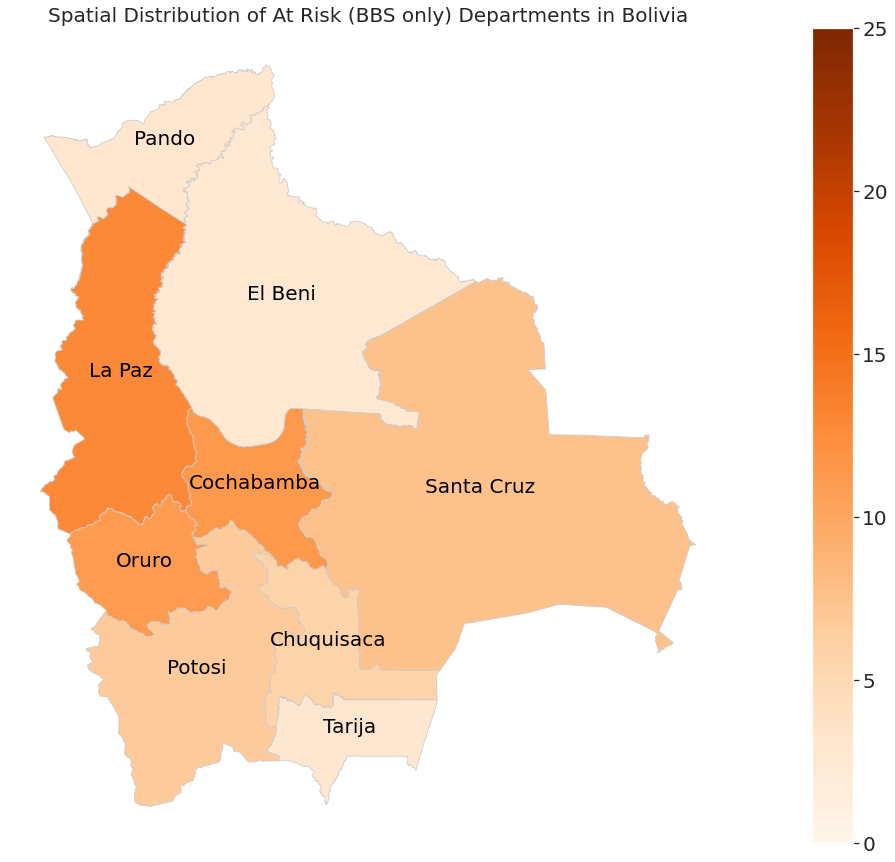

In [17]:
fig, ax = plt.subplots(1, figsize=(30, 15))
ax.axis('off')
ax.set_title('Spatial Distribution of At Risk (BBS only) Departments in Bolivia', fontdict={'fontsize': '20', 'fontweight' : '3'})
color = 'Oranges'
vmin, vmax = 0, 25
# vmin, vmax = dep_merged.At_Risk.min(), dep_merged.At_Risk.max()
sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)
cbar.ax.tick_params(labelsize=20)
dep_merged.plot('BBS_Risk', cmap=color, vmin=vmin, vmax=vmax, linewidth=0.8, ax=ax, edgecolor='0.8', figsize=(30,15))
for x, y, label in zip(departments.geometry.centroid.x, departments.geometry.centroid.y, dep_merged.Department):
  ax.annotate(s=label, xy=(x,y), horizontalalignment='center', fontsize=20, color='black', wrap=True)
plt.show()

Turnout

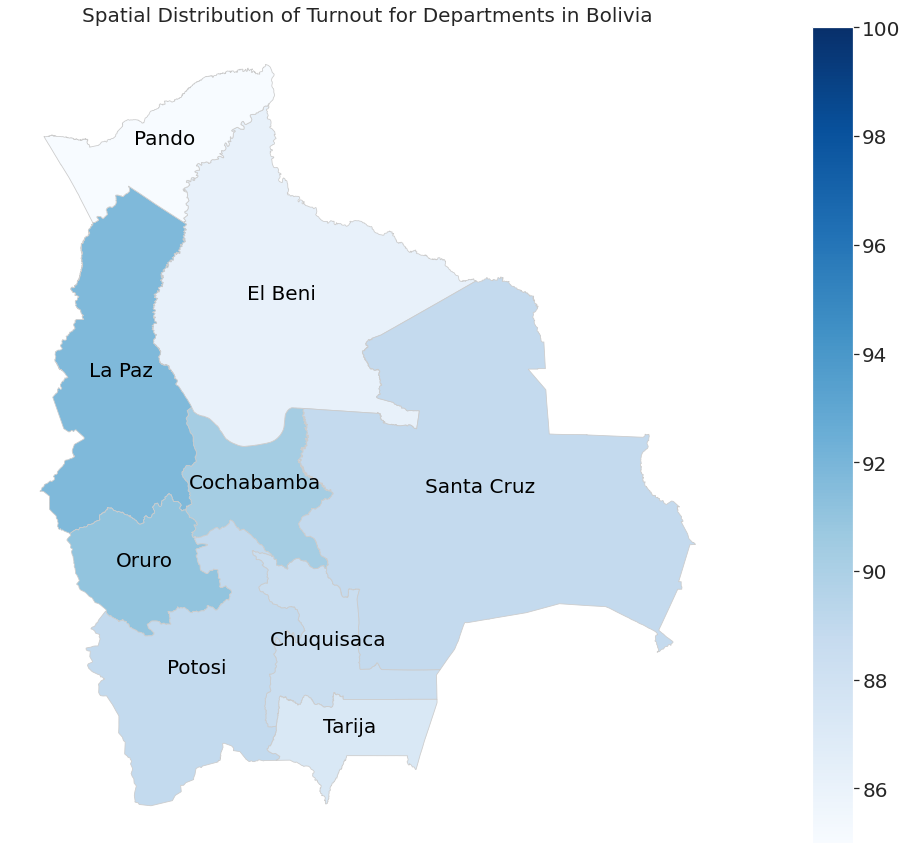

In [18]:
fig, ax = plt.subplots(1, figsize=(30, 15))
ax.axis('off')
ax.set_title('Spatial Distribution of Turnout for Departments in Bolivia', fontdict={'fontsize': '20', 'fontweight' : '3'})
color = 'Blues'
vmin, vmax = 85, 100
# vmin, vmax = dep_merged.At_Risk.min(), dep_merged.At_Risk.max()
sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)
cbar.ax.tick_params(labelsize=20)
dep_merged.plot('Avg_Turnout', cmap=color, vmin=vmin, vmax=vmax, linewidth=0.8, ax=ax, edgecolor='0.8', figsize=(30,15))
for x, y, label in zip(departments.geometry.centroid.x, departments.geometry.centroid.y, dep_merged.Department):
  ax.annotate(s=label, xy=(x,y), horizontalalignment='center', fontsize=20, color='black', wrap=True)
plt.show()

#Results by Municipality

At Risk (both VS and BBS)

In [19]:
mun_results['At_Risk'].mean()

22.200245398773

In [20]:
merged_at_risk = bolivia.set_index('Municipality').join(mun_results.set_index('Municipality'))
merged_at_risk = merged_at_risk.reset_index()
merged_at_risk = merged_at_risk.fillna(10)

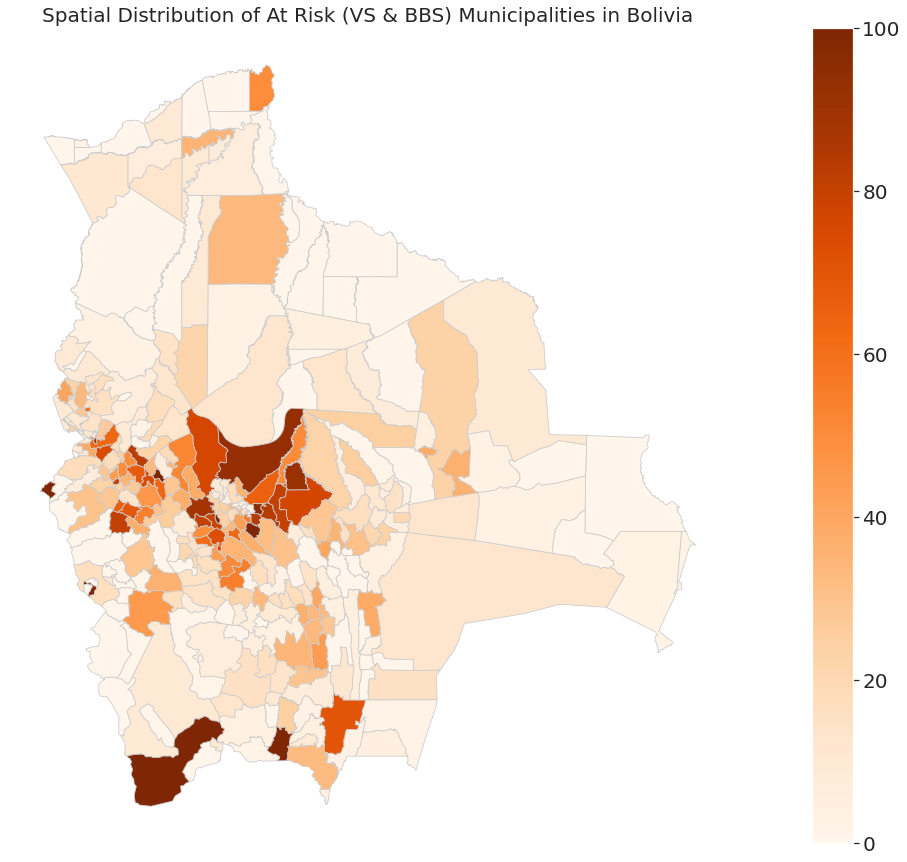

In [21]:
fig, ax = plt.subplots(1, figsize=(30, 15))
ax.axis('off')
ax.set_title('Spatial Distribution of At Risk (VS & BBS) Municipalities in Bolivia', fontdict={'fontsize': '20', 'fontweight' : '3'})
color = 'Oranges'
vmin, vmax = 0, 100
sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)
cbar.ax.tick_params(labelsize=20)
merged_at_risk.plot('At_Risk', cmap=color, vmin=vmin, vmax=vmax, linewidth=0.8, ax=ax, edgecolor='0.8', figsize=(30,15))
plt.show()

At Risk of VS

In [22]:
mun_results['VS_Risk'].mean()

12.915981595092038

In [23]:
merged_at_risk_vs = bolivia.set_index('Municipality').join(mun_results.set_index('Municipality'))
merged_at_risk_vs = merged_at_risk_vs.reset_index()
merged_at_risk_vs = merged_at_risk_vs.fillna(10)

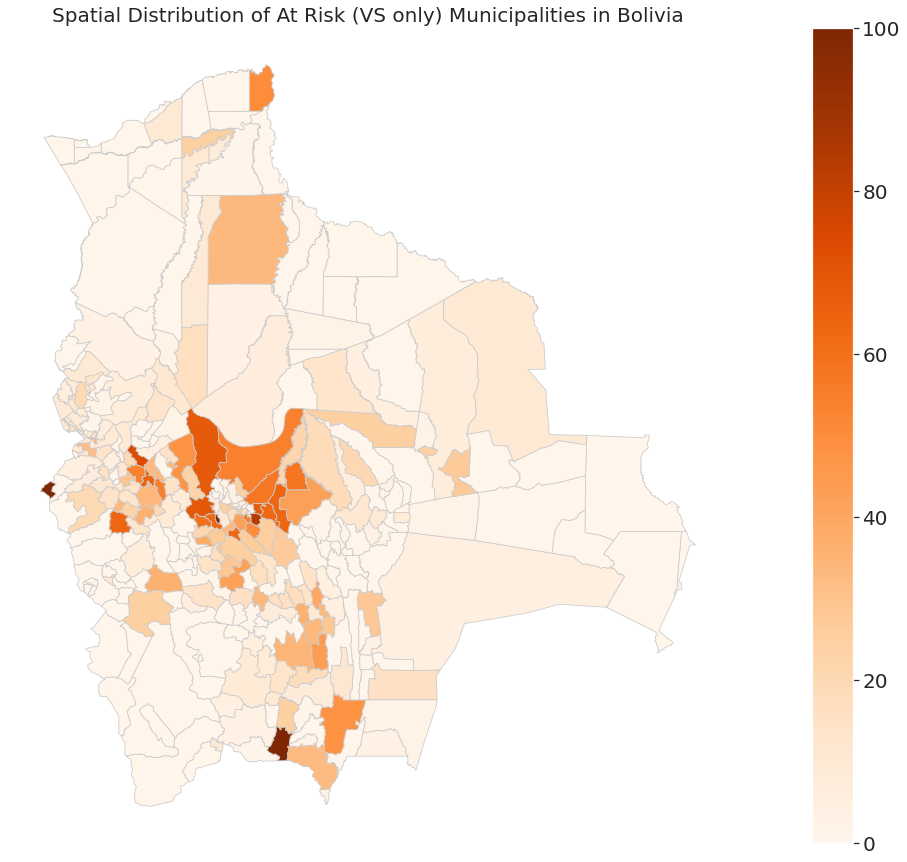

In [24]:
fig, ax = plt.subplots(1, figsize=(30, 15))
ax.axis('off')
ax.set_title('Spatial Distribution of At Risk (VS only) Municipalities in Bolivia', fontdict={'fontsize': '20', 'fontweight' : '3'})
color = 'Oranges'
vmin, vmax = 0, 100
sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)
cbar.ax.tick_params(labelsize=20)
merged_at_risk_vs.plot('VS_Risk', cmap=color, vmin=vmin, vmax=vmax, linewidth=0.8, ax=ax, edgecolor='0.8', figsize=(30,15))
plt.show()

At Risk of BBS

In [25]:
mun_results['BBS_Risk'].mean()

9.284049079754604

In [26]:
merged_at_risk_bbs = bolivia.set_index('Municipality').join(mun_results.set_index('Municipality'))
merged_at_risk_bbs = merged_at_risk_bbs.reset_index()
merged_at_risk_bbs = merged_at_risk_bbs.fillna(10)

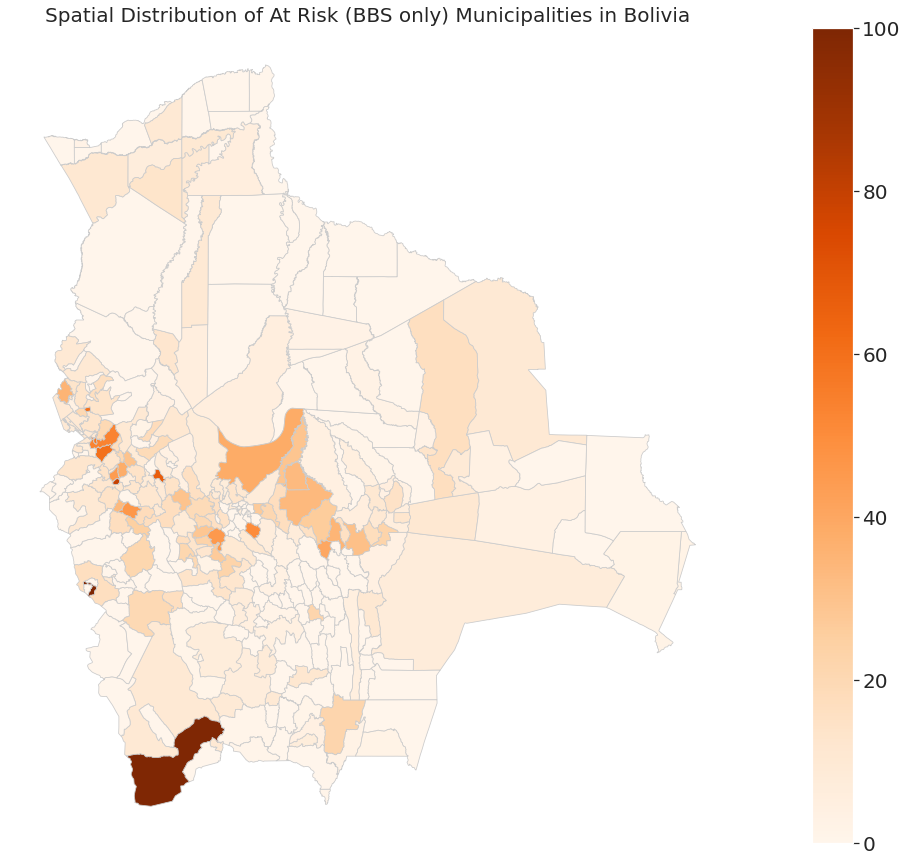

In [27]:
fig, ax = plt.subplots(1, figsize=(30, 15))
ax.axis('off')
ax.set_title('Spatial Distribution of At Risk (BBS only) Municipalities in Bolivia', fontdict={'fontsize': '20', 'fontweight' : '3'})
color = 'Oranges'
vmin, vmax = 0, 100
sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)
cbar.ax.tick_params(labelsize=20)
merged_at_risk_bbs.plot('BBS_Risk', cmap=color, vmin=vmin, vmax=vmax, linewidth=0.8, ax=ax, edgecolor='0.8', figsize=(30,15))
plt.show()

Turnout

In [28]:
mun_results['Avg_Turnout'].mean()

88.2750613496933

In [29]:
merged_turnout = bolivia.set_index('Municipality').join(mun_results.set_index('Municipality'))
merged_turnout = merged_turnout.reset_index()
merged_turnout = merged_turnout.fillna(88)

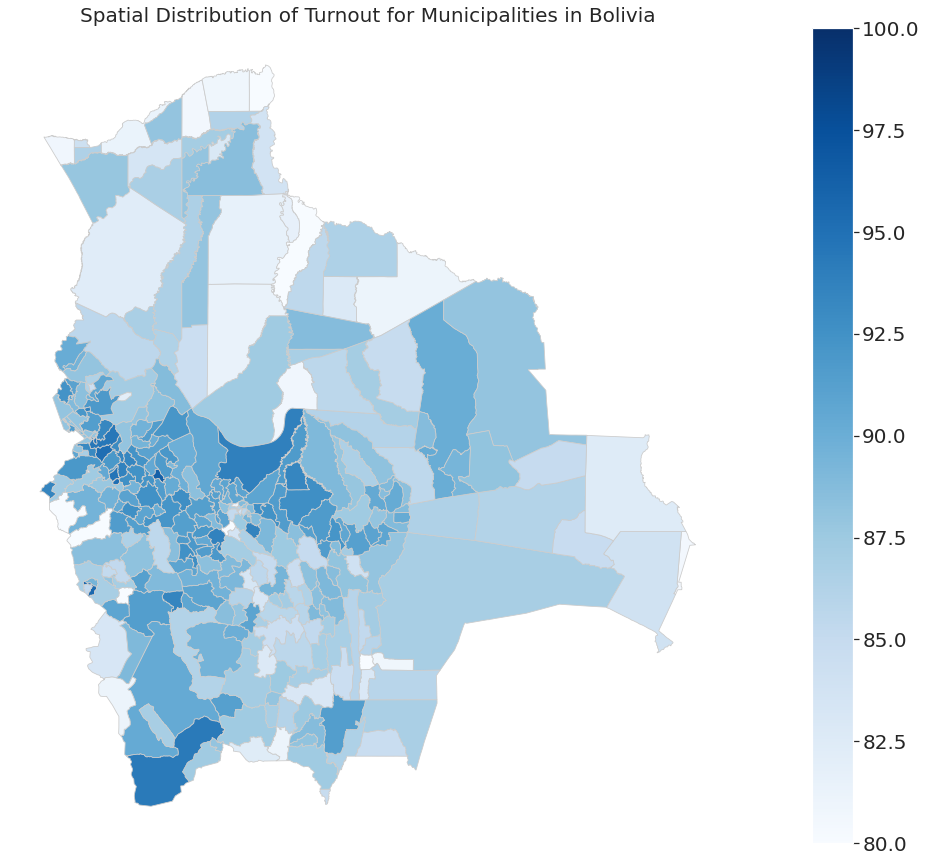

In [30]:
fig, ax = plt.subplots(1, figsize=(30, 15))
ax.axis('off')
ax.set_title('Spatial Distribution of Turnout for Municipalities in Bolivia', fontdict={'fontsize': '20', 'fontweight' : '3'})
color = 'Blues'
vmin, vmax = 80, 100
sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)
cbar.ax.tick_params(labelsize=20)
merged_turnout.plot('Avg_Turnout', cmap=color, vmin=vmin, vmax=vmax, linewidth=0.8, ax=ax, edgecolor='0.8', figsize=(30,15))
plt.show()